<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">The Chebyshev Pseudospectral Method - Elastic Waves in 1D</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* David Vargas ([@dvargas](https://github.com/davofis))
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))
---

## Basic Equations
Below there is the code solving the 1D acoustic wave equation

In [1]:
# This is a configuration step for the exercise. Please run it before calculating the derivative!
import numpy as np
import matplotlib.pyplot as plt
from ricker import ricker 

# Show the plots in the Notebook.
plt.switch_backend("nbagg")

### 1. Chebyshev derivative method

In [2]:
def get_cheby_matrix(nx):
    cx = np.zeros(nx+1)
    x = np.zeros(nx+1)
    for ix in range(0,nx+1):
        x[ix] = np.cos(np.pi * ix / nx)
   
    cx[0] = 2.
    cx[nx] = 2.
    cx[1:nx] = 1.
   
    D = np.zeros((nx+1,nx+1))
    for i in range(0, nx+1):
        for j in range(0, nx+1):
            if i==j and i!=0 and i!=nx:
                D[i,i]=-x[i]/(2.0*(1.0-x[i]*x[i]))
            else:
                D[i,j]=(cx[i]*(-1)**(i+j))/(cx[j]*(x[i]-x[j]))
  
    D[0,0] = (2.*nx**2+1.)/6.
    D[nx,nx] = -D[0,0]
    return D 

### 2. Initialization of setup

In [3]:
# Basic parameters
# ---------------------------------------------------------------
#nt = 5000        # number of time steps
tmax  = 0.0006
eps   = 1.4       # stability limit
isx   = 100
lw    = 0.7
ft    = 10
f0    = 100000    # dominant frequency
iplot = 20        # Snapshot frequency

# material parameters
rho = 2500.
c   = 3000.
mu  = rho*c**2

# space domain
nx = 199     # number of grid points in x 
xs = np.floor(nx/2)      # source location
xr = np.floor(nx*0.8)
x  = np.zeros(nx+1) 

# initialization of pressure fields
p = np.zeros(nx+1) 
pnew = np.zeros(nx+1)
pold = np.zeros(nx+1)
d2p  = np.zeros(nx+1) 

for ix in range(0,nx+1):
    x[ix] = np.cos(ix * np.pi / nx) 
dxmin = min(abs(np.diff(x)))
dxmax = max(abs(np.diff(x)))

dt = eps*dxmin/c    # calculate time step from stability criterion
nt = int(round(tmax/dt))

### 3. Source Initialization 

In [4]:
# source time function
# ---------------------------------------------------------------
t = np.arange(1, nt+1)*dt  # initialize time axis
T0 = 1./f0
tmp = ricker(dt, T0)
isrc = tmp
tmp = np.diff(tmp)
src = np.zeros(nt) 
src[0:np.size(tmp)] = tmp

#spatial source function
# ---------------------------------------------------------------
sigma = 1.5*dxmax
x0 = x[int(xs)]
sg = np.exp(-1/sigma**2*(x-x0)**2)
sg = sg/max(sg) 

### 4. Time Extrapolation

<IPython.core.display.Javascript object>


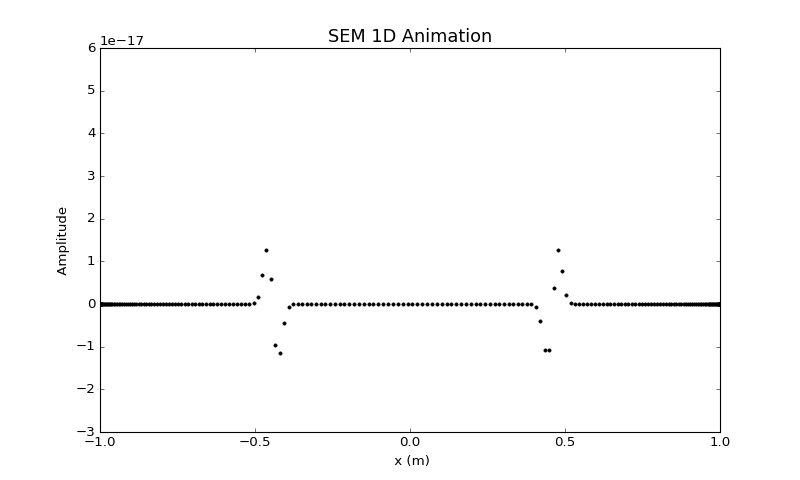

/home/david/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
# Initialize animated plot
# ---------------------------------------------------------------
#plt.figure(figsize=(12,4)) 
#line = plt.plot(x, p, 'k.', lw=1.5)
#ax1.axis([isx*dx, nx*dx, -6E-7, 6E-7])
#plt.ylabel('displacement')
#plt.xlabel('x')  

#plt.ion()   # set interective mode
#plt.show()

plt.figure(figsize=(10,6))
line = plt.plot(x, p, 'k.', lw=1.5)
plt.title('SEM 1D Animation', size=16)
plt.xlabel(' x (m)')
plt.ylabel(' Amplitude ')

plt.ion() # set interective mode
plt.show()
# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------
# Differentiation matrix
D = get_cheby_matrix(nx)
for it in range(nt):
    # Space derivatives
    dp = np.dot(D, np.transpose(p))
    dp = mu/rho * dp
    dp = np.dot(D, dp)
    
    # Time extrapolation 
    pnew = 2*p - pold + np.transpose(dp) * dt**2
    
    # Source injection
    pnew = pnew + sg*src[it]*dt**2/rho
    
    # Remapping
    pold, p = p, pnew
    p[0] = 0; p[nx] = 0 # set boundaries pressure free 

    # --------------------------------------   
    # Animation plot. Display solution
    if not it % iplot: 
        for l in line:
            l.remove()
            del l               
            
        # -------------------------------------- 
        # Display lines
        line = plt.plot(x, p, 'k.', lw=1.5)
        plt.gcf().canvas.draw()